<a href="https://colab.research.google.com/github/vggd18/LSTM-Bitcoin/blob/main/xLSTM_Bitcoin_vggd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install all the required dependency libraries
!pip install torch torchvision -q
!pip install numpy pandas matplotlib scikit-learn -q

# Importing the libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

## Carregando e Pré-processando dados

In [ ]:
# Loading the dataset
file_path = "./data-bitcoin_timedata_v2.csv"
# Decoding the uploaded file
btc = pd.read_csv(file_path)
btc.head()

,date,open,high,low,close,number_of_trades
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,3427
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,5233
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,2153
3,2017-08-20,4139.98,4211.08,4032.62,4086.29,2321
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,3972


In [ ]:
# Selecting the 'Close' price for prediction
data_to_use = btc['close'].values
print(data_to_use.shape)

(2176,)


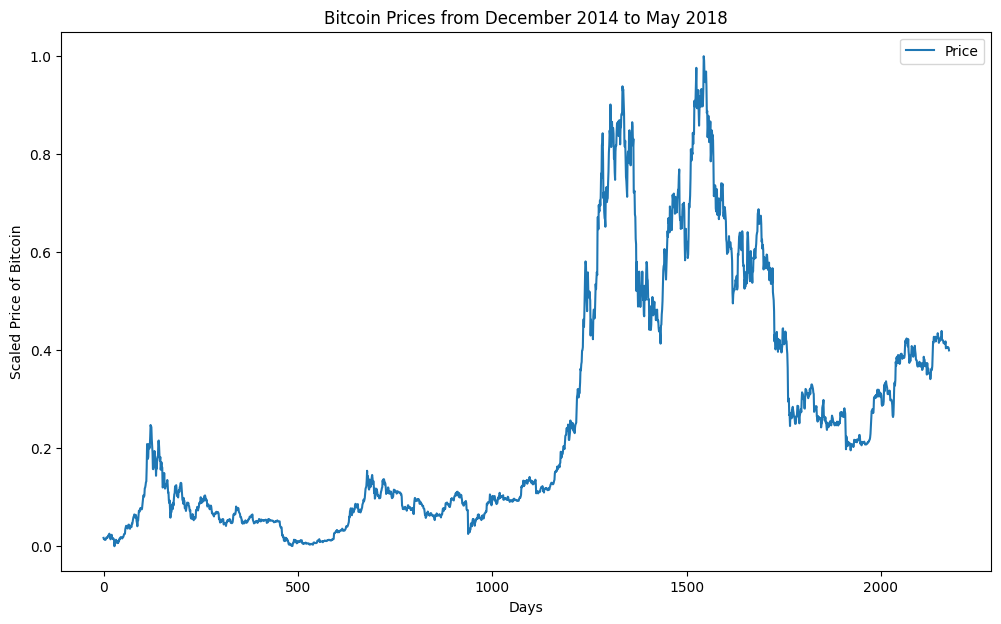

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

# Plotting the data
plt.figure(figsize=(12, 7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin Prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

## Criação das janelas e divisão em Teste/Treino

In [ ]:
def window_data(data, window_size):
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    assert len(X) == len(y)
    return np.array(X), np.array(y)

# Windowing the data
X, y = window_data(scaled_data, 30)

# Splitting the data into training and test sets
X_train = X[:1018]
y_train = y[:1018]
X_test = X[1018:]
y_test = y[1018:]

print(f"X_train size: {X_train.shape}")
print(f"y_train size: {y_train.shape}")
print(f"X_test size: {X_test.shape}")
print(f"y_test size: {y_test.shape}")

X_train size: (1018, 30, 1)
y_train size: (1018, 1)
X_test size: (1128, 30, 1)
y_test size: (1128, 1)


In [ ]:
# Converting data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

## Definição do Modelo da XLSTM

In [ ]:
!pip install mlstm_kernels xlstm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from xlstm import (
    xLSTMBlockStack, xLSTMBlockStackConfig,
    mLSTMBlockConfig, sLSTMBlockConfig,
    FeedForwardConfig, mLSTMLayerConfig, sLSTMLayerConfig
)

class xLSTMTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_blocks=2, context_length=7):
        super().__init__()
        cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=2)
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="cuda",
                    num_heads=2,
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent"
                ),
                feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu")
            ),
            context_length=context_length,
            num_blocks=num_blocks,
            embedding_dim=hidden_dim,
            slstm_at=[1],
        )

        self.block_stack = xLSTMBlockStack(cfg)
        self.input_proj = nn.Linear(input_size, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x_emb = self.input_proj(x)         # (seq_len, batch, hidden_dim)
        x_emb = x_emb.permute(1, 0, 2)     # (batch, seq_len, hidden_dim)
        y = self.block_stack(x_emb)        # (batch, seq_len, hidden_dim)
        out = y[:, -1, :]                  # last timestep
        return self.output_proj(out)       # (batch, output_size)

# ---------------------------
# Training setup
# ---------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = 1
output_size = 1
learning_rate = 1e-3
epochs = 200
patience = 30
batch_size = 32

model = xLSTMTimeSeries(input_size, 64, output_size, num_blocks=2, context_length=30).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Split validation set (10%)
val_split = int(0.1 * len(X_train))
X_val = X_train[-val_split:]
y_val = y_train[-val_split:]
X_train_fold = X_train[:-val_split]
y_train_fold = y_train[:-val_split]

# Create DataLoaders
train_dataset = TensorDataset(X_train_fold, y_train_fold)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

best_val_loss = float("inf")
patience_counter = 0

# ---------------------------
# Training loop
# ---------------------------

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for seq_batch, label_batch in train_loader:
        seq_batch = seq_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        y_pred = model(seq_batch.permute(1, 0, 2))
        loss = loss_function(y_pred.squeeze(), label_batch.squeeze())

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item() * seq_batch.size(0)

    train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seq_batch, label_batch in val_loader:
            seq_batch = seq_batch.to(device)
            label_batch = label_batch.to(device)

            y_pred = model(seq_batch.permute(1, 0, 2))
            loss = loss_function(y_pred.squeeze(), label_batch.squeeze())

            val_loss += loss.item() * seq_batch.size(0)
    val_loss /= len(val_loader.dataset)

    if epoch % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}. Best val loss: {best_val_loss:.6f}")
        model.load_state_dict(best_model_state)
        break

# ---------------------------
# Prediction
# ---------------------------

model.eval()
train_preds, test_preds = [], []

print("\nGenerating predictions...")
with torch.no_grad():
    for seq in X_train:
        seq = seq.to(device)
        pred = model(seq.unsqueeze(1)).item()
        train_preds.append(pred)

    for seq in X_test:
        seq = seq.to(device)
        pred = model(seq.unsqueeze(1)).item()
        test_preds.append(pred)

# Inverse transform
train_preds_actual = scaler.inverse_transform(np.array(train_preds).reshape(-1, 1))
test_preds_actual = scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))

print(f"\nPrediction Statistics:")
print(f"Train predictions - Min: {train_preds_actual.min():.2f}, Max: {train_preds_actual.max():.2f}, Mean: {train_preds_actual.mean():.2f}")
print(f"Test predictions  - Min: {test_preds_actual.min():.2f}, Max: {test_preds_actual.max():.2f}, Mean: {test_preds_actual.mean():.2f}")
print(f"\nActual data range: {scaler.inverse_transform(scaled_data).min():.2f} to {scaler.inverse_transform(scaled_data).max():.2f}")

# ---------------------------
# Plot
# ---------------------------
window_size = 30
train_plot = np.empty_like(scaled_data)
train_plot[:] = np.nan
train_plot[window_size:len(train_preds_actual) + window_size, :] = train_preds_actual

test_plot = np.empty_like(scaled_data)
test_plot[:] = np.nan
test_start_index = len(train_preds_actual) + window_size
test_plot[test_start_index:test_start_index + len(test_preds_actual), :] = test_preds_actual

plt.figure(figsize=(16, 7))
plt.title('Bitcoin Price Prediction using xLSTM|')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data', alpha=0.7, linewidth=1.5)
plt.plot(train_plot, label='Training Predictions', linewidth=2, alpha=0.8)
plt.plot(test_plot, label='Testing Predictions', linewidth=2, alpha=0.8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_actual = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

train_rmse = np.sqrt(mean_squared_error(train_actual, train_preds_actual))
test_rmse = np.sqrt(mean_squared_error(test_actual, test_preds_actual))

print(f"\nPerformance Metrics:")
print(f"Train RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")

/usr/local/lib/python3.12/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.12/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


Epoch 000 | Train Loss: 0.050464 | Val Loss: 0.001344
Epoch 001 | Train Loss: 0.000432 | Val Loss: 0.000089
Epoch 002 | Train Loss: 0.000078 | Val Loss: 0.000025
Epoch 003 | Train Loss: 0.000068 | Val Loss: 0.000022
Epoch 004 | Train Loss: 0.000064 | Val Loss: 0.000038
Epoch 010 | Train Loss: 0.000158 | Val Loss: 0.000029
Epoch 020 | Train Loss: 0.000073 | Val Loss: 0.000077
